In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib
from warnings import filterwarnings
import string
from wordcloud import WordCloud
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

In [2]:
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
stops = stopwords.words('english')
lem = spacy.load('en_core_web_sm')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
from google.colab import drive

In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
filterwarnings(action='ignore')
plt.style.use('ggplot')
pal = sns.color_palette()
matplotlib.rc('axes.formatter', useoffset=False)

In [7]:
train_df = pd.read_csv('/content/drive/My Drive/quera_qp/dataset/train.csv')
test_df = pd.read_csv('/content/drive/My Drive/quera_qp/dataset/test.csv')

In [8]:
train_df

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
...,...,...,...,...,...,...
404285,404285,433578,379845,How many keywords are there in the Racket prog...,How many keywords are there in PERL Programmin...,0
404286,404286,18840,155606,Do you believe there is life after death?,Is it true that there is life after death?,1
404287,404287,537928,537929,What is one coin?,What's this coin?,0
404288,404288,537930,537931,What is the approx annual cost of living while...,I am having little hairfall problem but I want...,0


## EDA

In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [69]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3563475 entries, 0 to 3563474
Data columns (total 10 columns):
 #   Column                Dtype 
---  ------                ----- 
 0   test_id               object
 1   question1             object
 2   question2             object
 3   q1_num_of_words       int64 
 4   q2_num_of_words       int64 
 5   q1_num_of_chars       int64 
 6   q2_num_of_chars       int64 
 7   q1_clean              object
 8   q2_clean              object
 9   num_of_common_tokens  int64 
dtypes: int64(5), object(5)
memory usage: 271.9+ MB


In [11]:
train_df.isnull().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

In [12]:
train_df[train_df['question1'].isnull() == True]

,id,qid1,qid2,question1,question2,is_duplicate
363362,363362,493340,493341,NaN,My Chinese name is Haichao Yu. What English na...,0


In [13]:
train_df[train_df['question2'].isnull() == True]

,id,qid1,qid2,question1,question2,is_duplicate
105780,105780,174363,174364,How can I develop android app?,NaN,0
201841,201841,303951,174364,How can I create an Android app?,NaN,0


In [14]:
train_df.drop(train_df[train_df['question2'].isnull() == True].index, inplace=True)
train_df.drop(train_df[train_df['question1'].isnull() == True].index, inplace=True)

In [15]:
test_df.isnull().sum()

test_id      0
question1    4
question2    6
dtype: int64

In [76]:
test_df[test_df['question1'].isnull() == True]

,test_id,question1,question2,q1_num_of_words,q2_num_of_words,q1_num_of_chars,q2_num_of_chars,q1_clean,q2_clean,num_of_common_tokens


In [17]:
test_df[test_df['question2'].isnull() == True]

,test_id,question1,question2
379205,379205,How I can learn android app development?,NaN
817520,817520,How real can learn android app development?,NaN
943911,943911,How app development?,NaN
1270024,1270024,How I can learn app development?,NaN
2345796,"life in dublin?""",NaN,NaN
2487703,1270024,How I can learn app development?,NaN


In [18]:
test_df[test_df['test_id']]
test_df[test_df['question1'].isnull()] = 'null question'
test_df[test_df['question2'].isnull()] = 'null question'

## we'll take care of that later

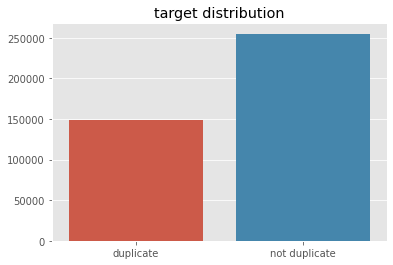

In [19]:
dist = [train_df[train_df['is_duplicate'] == 1]['is_duplicate'].count(
), train_df[train_df['is_duplicate'] == 0]['is_duplicate'].count()]

sns.barplot(x=['duplicate', 'not duplicate'], y=dist)
plt.title('target distribution')
plt.show()

In [20]:
dist

[149263, 255024]

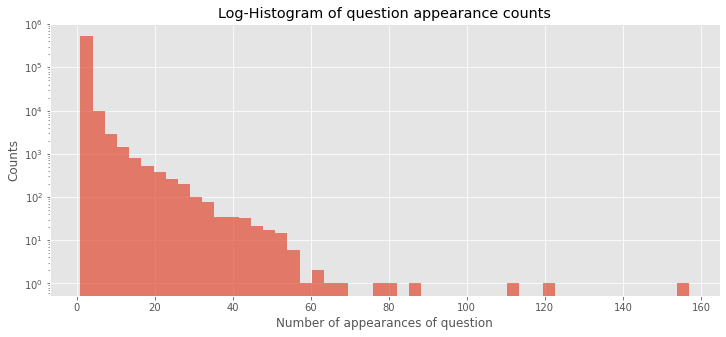

In [21]:
# question appearance count

qids = pd.Series(train_df['qid1'].tolist() + train_df['qid2'].tolist())

plt.figure(figsize=(12, 5))
plt.hist(qids.value_counts(), bins=50, color=pal[0], alpha=0.7)
plt.yscale('log', nonposy='clip')
plt.title('Log-Histogram of question appearance counts')
plt.xlabel('Number of appearances of question')
plt.ylabel('Counts')
plt.show()

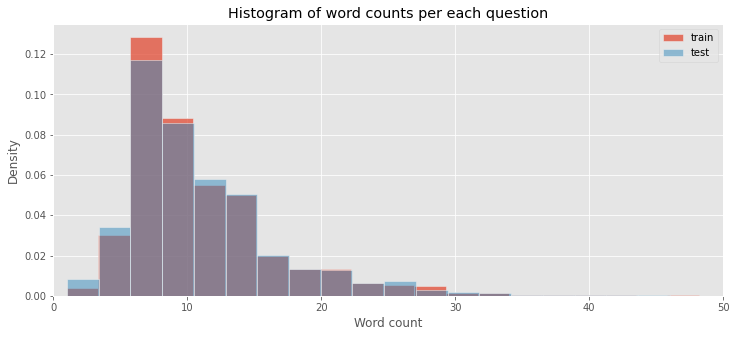

In [22]:
# word count

train_qs = pd.Series(train_df['question1'] + train_df['question2']).astype(str)
test_qs = pd.Series(test_df['question1'] + test_df['question2']).astype(str)

train_df['q1_num_of_words'] = train_df['question1'].apply(lambda x: len(x.split(' ')))
train_df['q2_num_of_words'] = train_df['question2'].apply(lambda x: len(x.split(' ')))
test_df['q1_num_of_words'] = test_df['question1'].apply(lambda x: len(x.split(' ')))
test_df['q2_num_of_words'] = test_df['question2'].apply(lambda x: len(x.split(' ')))

fig, ax = plt.subplots(figsize=(12, 5))
x = np.hstack((train_df['q1_num_of_words'], train_df['q2_num_of_words'])).tolist()
sns.histplot(x, bins=100, ax=ax,
             color=pal[0], label='train', stat='density')

x = np.hstack((test_df['q1_num_of_words'], test_df['q2_num_of_words'])).tolist()
sns.histplot(x, bins=100, ax=ax,
             color=pal[1], label='test', alpha=0.5, stat='density')
plt.title('Histogram of word counts per each question')
plt.xlabel('Word count')
ax.set_xlim(0, 50)
plt.legend()
plt.show()

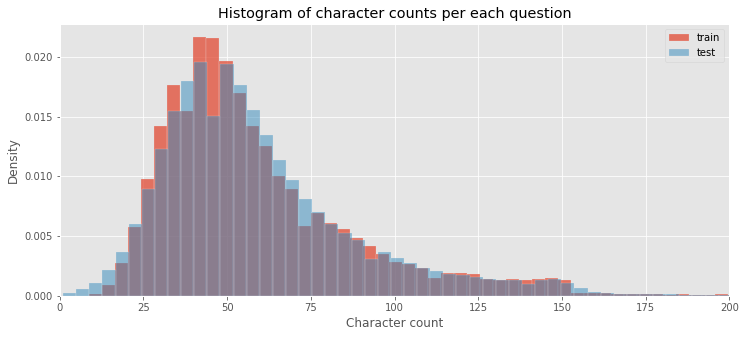

In [23]:
# character count 

train_df['q1_num_of_chars'] = train_df['question1'].apply(lambda x: len(x))
train_df['q2_num_of_chars'] = train_df['question2'].apply(lambda x: len(x))
test_df['q1_num_of_chars'] = test_df['question1'].apply(lambda x: len(x))
test_df['q2_num_of_chars'] = test_df['question2'].apply(lambda x: len(x))

fig, ax = plt.subplots(figsize=(12, 5))

x = np.hstack((train_df['q1_num_of_chars'], train_df['q2_num_of_chars'])).tolist()
sns.histplot(x, bins=300, ax=ax,
             color=pal[0], label='train', stat='density')

x = np.hstack((test_df['q1_num_of_chars'], test_df['q2_num_of_chars'])).tolist()
sns.histplot(x, bins=300, ax=ax,
             color=pal[1], label='test', alpha=0.5, stat='density')
plt.title('Histogram of character counts per each question')
plt.xlabel('Character count')
ax.set_xlim(0, 200)
plt.legend()
plt.show()

In [24]:
# appearance of punks

puncts = string.punctuation
train_puncts_count = {}
test_puncts_count = {}
for p in puncts:
    train_puncts_count[p] = np.sum(train_qs.apply(lambda x: p in x))
    test_puncts_count[p] = np.sum(test_qs.apply(lambda x: p in x))
    
train_puncts_count = {k: v for k, v in sorted(train_puncts_count.items(), key=lambda item: item[1], reverse=True)}
test_puncts_count = {k: v for k, v in sorted(test_puncts_count.items(), key=lambda item: item[1], reverse=True)}

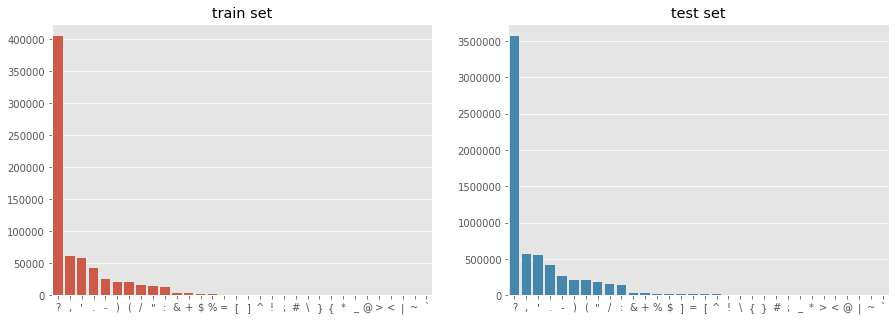

In [25]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
plt.ticklabel_format(style='plain')

sns.barplot(x=list(train_puncts_count.keys()), y=list(train_puncts_count.values()), color=pal[0], ax=axs[0])
axs[0].set(title='train set')
sns.barplot(x=list(test_puncts_count.keys()), y=list(test_puncts_count.values()), color=pal[1], ax=axs[1])
axs[1].set(title='test set')
plt.show()

## Text cleaning

In [26]:
def decontracter(text):
    contractions = {
        "ain't": "am not",
        "aren't": "are not",
        "can't": "can not",
        "can't've": "can not have",
        "'cause": "because",
        "could've": "could have",
        "couldn't": "could not",
        "couldn't've": "could not have",
        "didn't": "did not",
        "doesn't": "does not",
        "don't": "do not",
        "hadn't": "had not",
        "hadn't've": "had not have",
        "hasn't": "has not",
        "haven't": "have not",
        "he'd": "he would",
        "he'd've": "he would have",
        "he'll": "he will",
        "he'll've": "he will have",
        "he's": "he is",
        "how'd": "how did",
        "how'd'y": "how do you",
        "how'll": "how will",
        "how's": "how is",
        "i'd": "i would",
        "i'd've": "i would have",
        "i'll": "i will",
        "i'll've": "i will have",
        "i'm": "i am",
        "i've": "i have",
        "isn't": "is not",
        "it'd": "it would",
        "it'd've": "it would have",
        "it'll": "it will",
        "it'll've": "it will have",
        "it's": "it is",
        "let's": "let us",
        "ma'am": "madam",
        "mayn't": "may not",
        "might've": "might have",
        "mightn't": "might not",
        "mightn't've": "might not have",
        "must've": "must have",
        "mustn't": "must not",
        "mustn't've": "must not have",
        "needn't": "need not",
        "needn't've": "need not have",
        "o'clock": "of the clock",
        "oughtn't": "ought not",
        "oughtn't've": "ought not have",
        "shan't": "shall not",
        "sha'n't": "shall not",
        "shan't've": "shall not have",
        "she'd": "she would",
        "she'd've": "she would have",
        "she'll": "she will",
        "she'll've": "she will have",
        "she's": "she is",
        "should've": "should have",
        "shouldn't": "should not",
        "shouldn't've": "should not have",
        "so've": "so have",
        "so's": "so as",
        "that'd": "that would",
        "that'd've": "that would have",
        "that's": "that is",
        "there'd": "there would",
        "there'd've": "there would have",
        "there's": "there is",
        "they'd": "they would",
        "they'd've": "they would have",
        "they'll": "they will",
        "they'll've": "they will have",
        "they're": "they are",
        "they've": "they have",
        "to've": "to have",
        "wasn't": "was not",
        "we'd": "we would",
        "we'd've": "we would have",
        "we'll": "we will",
        "we'll've": "we will have",
        "we're": "we are",
        "we've": "we have",
        "weren't": "were not",
        "what'll": "what will",
        "what'll've": "what will have",
        "what're": "what are",
        "what's": "what is",
        "what've": "what have",
        "when's": "when is",
        "when've": "when have",
        "where'd": "where did",
        "where's": "where is",
        "where've": "where have",
        "who'll": "who will",
        "who'll've": "who will have",
        "who's": "who is",
        "who've": "who have",
        "why's": "why is",
        "why've": "why have",
        "will've": "will have",
        "won't": "will not",
        "won't've": "will not have",
        "would've": "would have",
        "wouldn't": "would not",
        "wouldn't've": "would not have",
        "y'all": "you all",
        "y'all'd": "you all would",
        "y'all'd've": "you all would have",
        "y'all're": "you all are",
        "y'all've": "you all have",
        "you'd": "you would",
        "you'd've": "you would have",
        "you'll": "you will",
        "you'll've": "you will have",
        "you're": "you are",
        "you've": "you have"
    }
    decontracted = []
    for word in text.split():
        if word in contractions:
            word = contractions[word]
        decontracted.append(word)
    text = ' '.join(decontracted)
    
    return text

In [27]:
def preprocessor(text):
    # lower case
    text = text.lower()

    # html tags and url remover
    text = re.sub(
        r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'<.*?>', '', text)

    # decontracter
    text = decontracter(text)

    # replacing some characters with string
    text = text.replace('%', ' percent')
    text = text.replace('$', ' dollar ')
    text = text.replace('₹', ' rupee ')
    text = text.replace('€', ' euro ')
    text = text.replace('@', ' at ')
    text = text.replace('w/o', 'without')
    text = text.replace('w8', 'wait')
    text = text.replace("'ve", " have")
    text = text.replace("n't", " not")
    text = text.replace("'re", " are")
    text = text.replace("'ll", " will")
    text = text.replace("[math]", '')
    text = text.replace("[/math]", '')

    # punctuantions remover
    text = ''.join([word for word in text if word not in string.punctuation])

    # emoji remover
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"
                               u"\U0001F300-\U0001F5FF"
                               u"\U0001F680-\U0001F6FF"
                               u"\U0001F1E0-\U0001F1FF"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    
    
    tokens = word_tokenize(text)
    no_stops_tokens = [x for x in tokens if x not in stops]
    
    doc = doc = spacy.tokens.Doc(lem.vocab, words=no_stops_tokens)
    reverted_to_base = []
    for token in doc:
      reverted_to_base.append(token.lemma_)

    return ' '.join(reverted_to_base)

In [28]:
def common_tokens(q1, q2):
  q1_token = word_tokenize(q1)
  q2_token = word_tokenize(q2)

  return len(list(set(q1_token).intersection(q2_token)))

In [29]:
# text cleaning

train_df['q1_clean'] = train_df['question1'].apply(lambda x: preprocessor(x))
train_df['q2_clean'] = train_df['question2'].apply(lambda x: preprocessor(x))

test_df['q1_clean'] = test_df['question1'].apply(lambda x: preprocessor(x))
test_df['q2_clean'] = test_df['question2'].apply(lambda x: preprocessor(x))


In [30]:
# getting common tokens

train_df['num_of_common_tokens'] = train_df.apply(lambda x: common_tokens(x['q1_clean'], x['q2_clean']), axis=1)
test_df['num_of_common_tokens'] = test_df.apply(lambda x: common_tokens(x['q1_clean'], x['q2_clean']), axis=1)

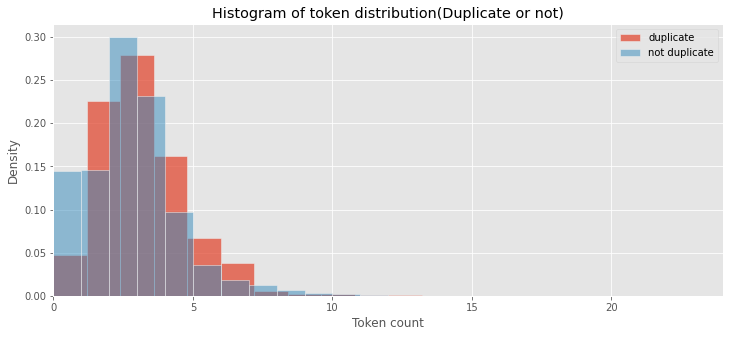

In [31]:
fig, ax = plt.subplots(figsize=(12, 5))

x = train_df[train_df['is_duplicate']==1]['num_of_common_tokens'].to_list()
sns.histplot(x, bins=20, ax=ax,
             color=pal[0], label='duplicate', stat='density')

x = train_df[train_df['is_duplicate']==0]['num_of_common_tokens'].to_list()
sns.histplot(x, bins=20, ax=ax,
             color=pal[1], label='not duplicate', alpha=0.5, stat='density')

plt.title('Histogram of token distribution(Duplicate or not)')
plt.xlabel('Token count')
ax.set_xlim(0, 24)
plt.legend()
plt.show()

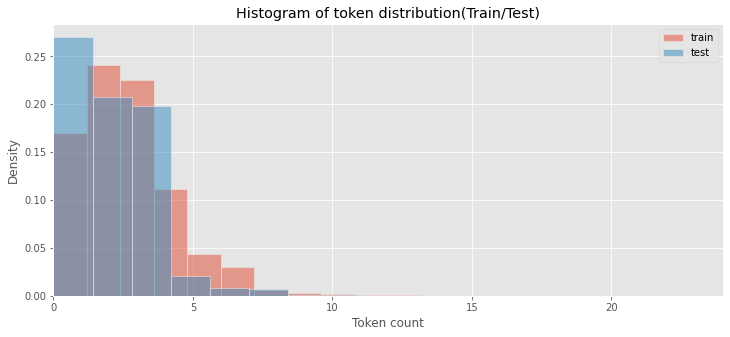

In [32]:
fig, ax = plt.subplots(figsize=(12, 5))
x = train_df['num_of_common_tokens'].to_list()
sns.histplot(x, bins=20, ax=ax,
             color=pal[0], label='train', alpha=0.5, stat='density')

x = test_df['num_of_common_tokens'].to_list()
sns.histplot(x, bins=20, ax=ax,
             color=pal[1], label='test', alpha=0.5, stat='density')
plt.title('Histogram of token distribution(Train/Test)')
plt.xlabel('Token count')
ax.set_xlim(0, 24)
plt.legend()
plt.show()

In [33]:
# to do: balancing the target distribution

## Vectorization

In [34]:
questions = list(list(train_df['q1_clean'] + list(train_df['q2_clean']))) 

vectorizer = TfidfVectorizer()
vectorizer.fit(questions)

tfidf_q1_vecs_train = vectorizer.transform(train_df['q1_clean'].values)
tfidf_q2_vecs_train = vectorizer.transform(train_df['q2_clean'].values)
tfidf_q1_vecs_test = vectorizer.transform(test_df['q1_clean'].values)
tfidf_q2_vecs_test = vectorizer.transform(test_df['q2_clean'].values)

idf = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))

tfidf_q1_train = pd.DataFrame.sparse.from_spmatrix(tfidf_q1_vecs_train)
tfidf_q2_train = pd.DataFrame.sparse.from_spmatrix(tfidf_q2_vecs_train)
tfidf_q1_test = pd.DataFrame.sparse.from_spmatrix(tfidf_q1_vecs_test)
tfidf_q2_test = pd.DataFrame.sparse.from_spmatrix(tfidf_q2_vecs_test)

## train test split

In [35]:
# temp = train_df[['q1_clean', 'q2_clean', 'is_duplicate']]

# # undersampling
# X = temp.drop(temp[temp['is_duplicate'] == 0].sample(n=150000).index)
# y = X['is_duplicate']
# X = X.drop(columns=['is_duplicate'], axis=1)

# # splitting
# X_train, X_val, y_train, y_val = train_test_split(X.to_numpy(), y.to_numpy(), random_state=42, test_size=0.15)

In [36]:
!pip install lightgbm

In [37]:
from scipy.sparse.construct import hstack

X_qs = hstack((tfidf_q1_vecs_train, tfidf_q2_vecs_train))
X_test = hstack((tfidf_q1_vecs_test, tfidf_q2_vecs_test))

X_train, X_val, y_train, y_val = train_test_split(X_qs, train_df['is_duplicate'], random_state=42, test_size=0.2)

## Modeling

In [38]:
from lightgbm import LGBMClassifier

lgbm = LGBMClassifier(random_state=42, learning_rate=0.8)
lgbm.fit(X_train, y_train)

LGBMClassifier(learning_rate=0.8, random_state=42)

In [39]:
from sklearn.metrics import accuracy_score

y_pred = lgbm.predict(X_val)
accuracy_score(y_val, y_pred)

0.7652551386381063

In [44]:
y_pred = lgbm.predict(X_test)

In [46]:
sub = pd.DataFrame({'test_id': test_df['test_id'], 'is_duplicate': y_pred})
sub

,test_id,is_duplicate
0,0,0
1,1,0
2,2,0
3,3,0
4,4,1
...,...,...
3563470,2345791,0
3563471,2345792,0
3563472,2345793,0
3563473,2345794,0


In [48]:
sub.to_csv('submission.csv', index=False)

In [53]:
## to do: take care of null questions of the test set in a decent way.